In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [33]:
path= ("/content/drive/MyDrive/T1.csv")
df = pd.read_csv(path)
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [34]:
# --- Tiền xử lý ---
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
data = df[features].values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [35]:
# --- Dataset dạng sliding window ---
SEQ_LEN = 24

In [36]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        return self.data[idx:idx+self.seq_len]

In [37]:
dataset = TimeSeriesDataset(data_scaled, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [38]:
# --- Mô hình Transformer Encoder ---
class TransformerEncoder(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.linear_in = nn.Linear(feature_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(d_model, d_model)

    def forward(self, x):
        x = self.linear_in(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # lấy trung bình theo chiều thời gian
        return self.linear_out(x)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerEncoder(feature_dim=4).to(device)

In [40]:
# --- Trích xuất đặc trưng ---
model.eval()
features_list = []

In [41]:
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        out = model(batch)
        features_list.append(out.cpu().numpy())

features_array = np.vstack(features_list)

In [42]:
# --- PCA để giảm chiều và trực quan ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_array)

In [30]:
# --- Gaussian Mixture Model ---
# --- Gaussian Mixture Model ---
gmm = GaussianMixture(n_components=3, random_state=42, verbose=2)
clusters = gmm.fit_predict(features_array)


Initialization 0
  Iteration 10	 time lapse 6.88730s	 ll change 0.01802
  Iteration 20	 time lapse 3.80657s	 ll change 0.01146
Initialization converged. time lapse 17.25802s	 lower bound 246.39160.


In [43]:
# --- Lấy tọa độ trọng tâm cụm sau khi PCA ---
centroids_pca = pca.transform(gmm.means_)

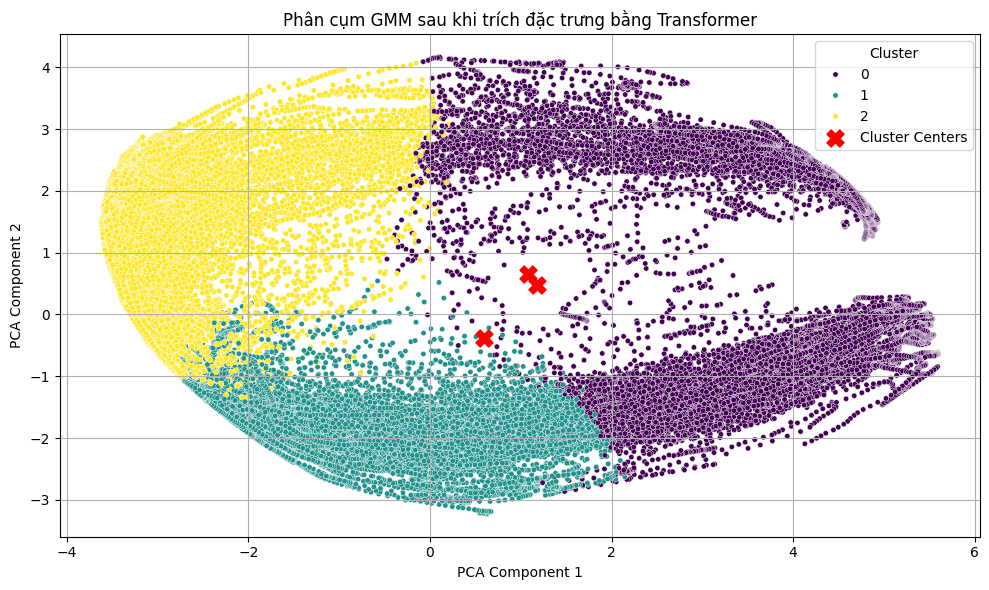

In [44]:
# --- Vẽ kết quả phân cụm + trọng tâm ---
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="viridis", s=15)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red', marker='X', s=150, label='Cluster Centers')
plt.title("Phân cụm GMM sau khi trích đặc trưng bằng Transformer")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()